### Based on the excellent nb from
https://www.kaggle.com/dktalaicha/credit-card-fraud-detection-using-smote-adasyn

* The data is very skewed - there are only 0.17% fraudulent transactions in the 280k samples - accuracy is not a good metric: any "model" predicting ALL are normal transactions will have a 99.83% accuracy.
* We need to use Recall, Precision and their prodigy (harmonic mean) - the F1 score. 

### The main modifications I've done to the original:
* Instead of oversampling and then split into train/test = ***data leakage*** ... I've first split into train/test and then oversampled ONLY on train
* Focus on F1 (as ROC AUC is not a good metric for imbalanced datasets)
* See my previous nb comparing 6 anomaly detection algorithms at https://www.kaggle.com/drscarlat/compare-6-unsupervised-anomaly-detection-models ... that one achieved **F1 = 0.8** on test.

* The original compared between Logistic Regression, Decision Trees, Random Forest, etc. I've added a NN to the list. 
* F1 score on Test using **undersampling, oversampling, SMOTE & ADASYN**:

### The best performance is RF SMOTE ... F1 = 0.87 on test**

Model	F1Score_Test
* RF SMOTE	0.867384
* RF ADASYN	0.855072
* RF Oversampling	0.853933
* DT Oversampling	0.747405
* DT ADASYN	0.508393
* DT SMOTE	0.480519
* RF Undersampling	0.151637
* Oversampling	0.121874
* LR SMOTE	0.115830
* LR Undersampling	0.102721
...
### Best NN = 0.82
* NN - over ... F1 = 0.82
* NN - smote ... F1 = 0.81
* NN - adasyn ... F1 = 0.79


# **Credit Card Fraud Detection**
**Anonymized credit card transactions labeled as fraudulent or genuine**

<img src="https://i.imgur.com/lBuWqxx.png" />

# <a id='introduction'>Introduction</a>


The datasets contain transactions that have 492 frauds out of 284,807 transactions. So the dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. When we try to build the prediction model with this kind of unbalanced dataset, then the model will be more inclined towards to detect new unseen transaction as genuine as our dataset contains about 99% genuine data.

As our dataset is highly imbalanced, so we shouldn't use accuracy score as a metric because it will be usually high and misleading, instead use we should focus on f1-score, precision/recall score or confusion matrix.

# <a id='dataset'>Load Data</a>

In [1]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import cufflinks as cf
import plotly
import datetime
import math
import matplotlib
import sklearn
from IPython.display import HTML
#from IPython.display import YouTubeVideo

import pickle
import os

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split

# Print versions of libraries
print(f"Numpy version : Numpy {np.__version__}")
print(f"Pandas version : Pandas {pd.__version__}")
print(f"Matplotlib version : Matplotlib {matplotlib.__version__}")
print(f"Seaborn version : Seaborn {sns.__version__}")
print(f"SkLearn version : SkLearn {sklearn.__version__}")
# print(f"Cufflinks version : cufflinks {cf.__version__}")
print(f"Plotly version : plotly {plotly.__version__}")

# Magic Functions for In-Notebook Display
%matplotlib inline

# Setting seabon style
sns.set(style='darkgrid', palette='colorblind')

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

Numpy version : Numpy 1.18.1
Pandas version : Pandas 1.0.3
Matplotlib version : Matplotlib 3.2.1
Seaborn version : Seaborn 0.10.0
SkLearn version : SkLearn 0.23.1
Plotly version : plotly 4.8.1


## Import the Dataset

In [2]:
df = pd.read_csv('../input/creditcardfraud/creditcard.csv', encoding='latin_1')
df.columns = df.columns.str.lower()
print(df.shape)
df.head()

(284807, 31)


,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## <a id='unique'>Count unique values of label</a>

In [3]:
print(df['class'].value_counts())
print('\n')
print(df['class'].value_counts(normalize=True))

0    284315
1       492
Name: class, dtype: int64


0    0.998273
1    0.001727
Name: class, dtype: float64


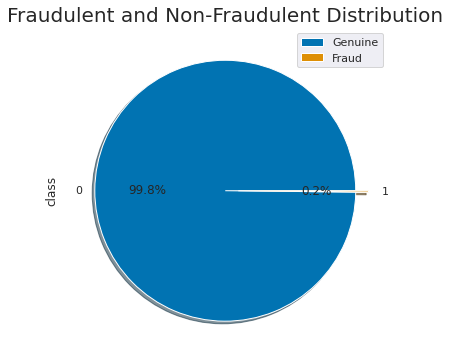

In [4]:
df["class"].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%',shadow=True)
plt.title("Fraudulent and Non-Fraudulent Distribution",fontsize=20)
plt.legend(["Genuine","Fraud"])
plt.show()

## <a id='null'>Finding null values</a>

In [5]:
# Dealing with missing data
df.isnull().sum().max()

0

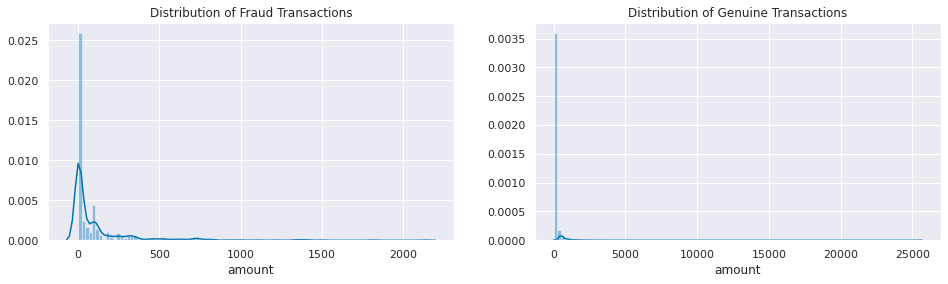

In [6]:
fig, axs = plt.subplots(ncols=2,figsize=(16,4))
sns.distplot(df[df['class'] == 1]['amount'], bins=100, ax=axs[0])
axs[0].set_title("Distribution of Fraud Transactions")

sns.distplot(df[df['class'] == 0]['amount'], bins=100, ax=axs[1])
axs[1].set_title("Distribution of Genuine Transactions")

plt.show()

**Highlights**

This graph shows that most of the fraud transaction amount is less than 500 dollars. This also shows that the fraud transaction is very high for an amount near to 0, let's find that amount.

In [7]:
print("Fraud Transaction distribution : \n",df[(df['class'] == 1)]['amount'].value_counts().head())
print("\n")
print("Maximum amount of fraud transaction - ",df[(df['class'] == 1)]['amount'].max())
print("Minimum amount of fraud transaction - ",df[(df['class'] == 1)]['amount'].min())

Fraud Transaction distribution : 
 1.00     113
0.00      27
99.99     27
0.76      17
0.77      10
Name: amount, dtype: int64


Maximum amount of fraud transaction -  2125.87
Minimum amount of fraud transaction -  0.0


**Highlights**

* There are 113 fraud transactions for just one dollor and 27 fraud transaction for $99.99. And higest fraud transaction amount was 2125.87 and lowest was just 0.00.
* There are 27 fraud transaction for zero amount. Zero Authorization is an account verification method for credit cards that is used to verify a cardholders information without charging the consumer. Instead, an amount of zero is charged on the card to store the credit card information in the form of a token and to determine whether the card is legitimate or not. After creating the token, is then possible to charge the consumer with a new transaction with either Tokenization or Recurring Payments

Ref : https://docs.multisafepay.com/tools/zero-authorization/what-is-zero-authorization/

In [8]:
print("Genuine Transaction distribution : \n",df[(df['class'] == 0)]['amount'].value_counts().head())
print("\n")
print("Maximum amount of Genuine transaction - ",df[(df['class'] == 0)]['amount'].max())
print("Minimum amount of Genuine transaction - ",df[(df['class'] == 0)]['amount'].min())

Genuine Transaction distribution : 
 1.00     13575
1.98      6044
0.89      4872
9.99      4746
15.00     3280
Name: amount, dtype: int64


Maximum amount of Genuine transaction -  25691.16
Minimum amount of Genuine transaction -  0.0


## <a id='timedist'>Distribution of Time</a>

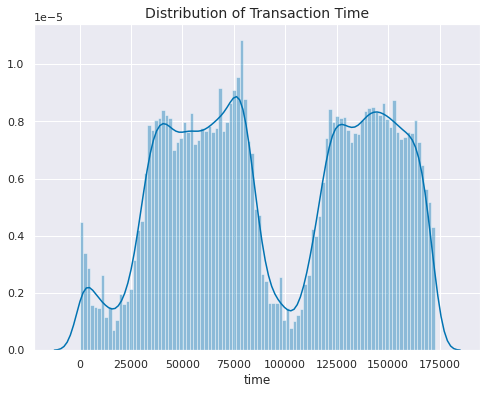

In [9]:
plt.figure(figsize=(8,6))
plt.title('Distribution of Transaction Time', fontsize=14)
sns.distplot(df['time'], bins=100)
plt.show()

**Highlights**

By seeing the graph, we can see there are two peaks in the graph and even there are some local peaks. We can think of these as the time of the day like the peak is the day time when most people do the transactions and the depth is the night time when most people just sleeps. We already know that data contains a credit card transaction for only two days, so there are two peaks for day time and one depth for one night time.

### Distribution of time w.r.t. transactions types

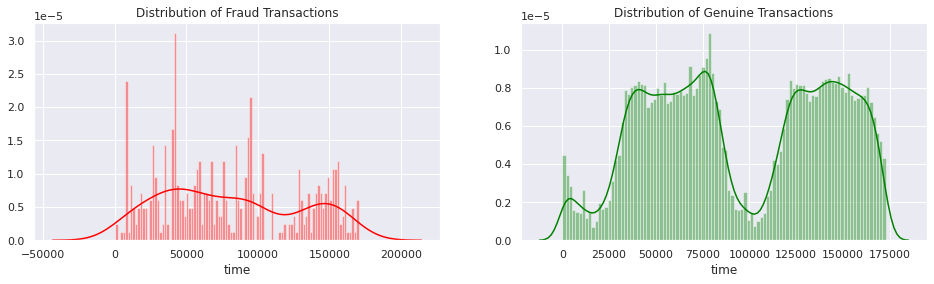

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(16,4))

sns.distplot(df[(df['class'] == 1)]['time'], bins=100, color='red', ax=axs[0])
axs[0].set_title("Distribution of Fraud Transactions")

sns.distplot(df[(df['class'] == 0)]['time'], bins=100, color='green', ax=axs[1])
axs[1].set_title("Distribution of Genuine Transactions")

plt.show()

## <a id='corr'>Correlation Among Explanatory Variables</a>

Having **too many features** in a model is not always a good thing because it might cause overfitting and worse results when we want to predict values for a new dataset. Thus, **if a feature does not improve your model a lot, not adding it may be a better choice.**

Another important thing is **correlation. If there is a very high correlation between two features, keeping both of them is not a good idea most of the time not to cause overfitting.** However, this does not mean that you must remove one of the highly correlated features. 

Let's find out top 10 features which are highly correlated with a price.

In [11]:
df[['time','amount','class']].corr()['class'].sort_values(ascending=False).head(10)

class     1.000000
amount    0.005632
time     -0.012323
Name: class, dtype: float64

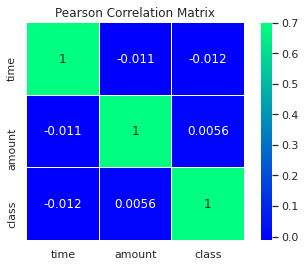

In [12]:
plt.title('Pearson Correlation Matrix')
sns.heatmap(df[['time', 'amount','class']].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="winter",
            linecolor='w',annot=True);

**Highlights**

It looks like that no features are highly correlated with any other features.

## Lets check the data again after cleaning

In [13]:
df.shape

(284807, 31)

In [14]:
df['class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: class, dtype: float64

# <a id='feateng'>Feature Engineering</a> 

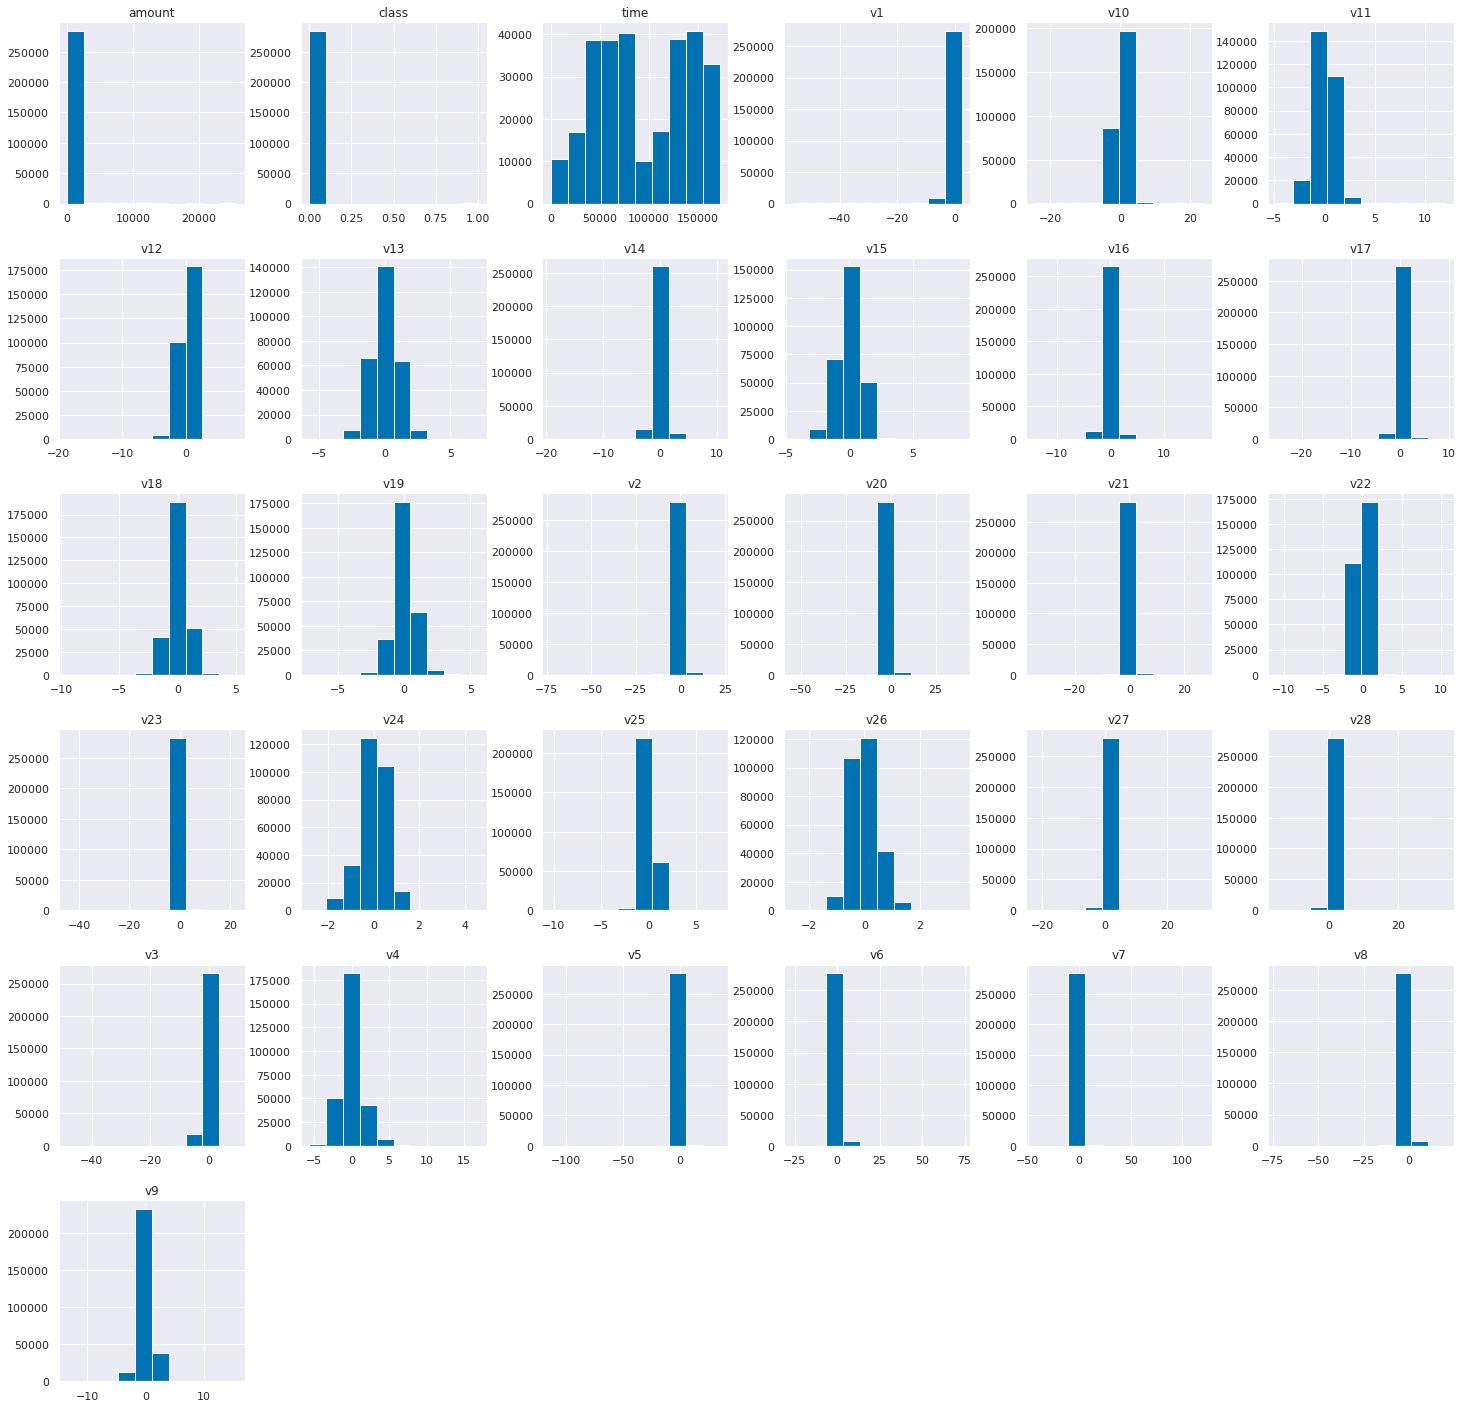

In [15]:
df.hist(figsize = (25,25))
plt.show()

## Reset the index

In [16]:
df.reset_index(inplace = True , drop = True)

# <a id='scaleamount'>Scale Amount Feature</a>

* It is a good idea to scale the data so that the column(feature) with lesser significance might not end up dominating the objective function due to its larger range. like a column like age has a range between 0 to 80, but a column like a salary has ranged from thousands to lakhs, hence, salary column will dominate to predict the outcome even if it may not be important.
* In addition, features having different unit should also be scaled thus providing each feature equal initial weightage. Like Age in years and Sales in Dollars must be brought down to a common scale before feeding it to the ML algorithm
* This will result in a better prediction model.



**PCA Transformation**: The description of the data says that all the features went through a PCA transformation (Dimensionality Reduction technique) except for time and amount.

**Scaling**: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

## <a id='scalelog'>1. Scale amount by Log</a>

**Scaling using the log**: There are two main reasons to use logarithmic scales in charts and graphs. 
* The first is to respond to skewness towards large values; i.e., cases in which one or a few points are much larger than the bulk of the data. 
* The second is to show per cent change or multiplicative factors. 

In [17]:
# Scale amount by log
df['amount_log'] = np.log(df.amount + 0.01)

## <a id='scalestand'>2. Scale  amount by Standardization</a>

Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.

$$ z = \frac{x_i - \mu}{\sigma} $$

In [18]:
from sklearn.preprocessing import StandardScaler # importing a class from a module of a library

ss = StandardScaler() # object of the class StandardScaler ()
df['amount_scaled'] = ss.fit_transform(df['amount'].values.reshape(-1,1))

## <a id='scalenorm'>3. Scale  amount by Normalization</a>

Normalization is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1. It is also known as Min-Max scaling.

$$ x_{norm} = \frac{x_i - x_{min}}{x_{max}-x_{min}} $$

In [19]:
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler() # object of the class StandardScaler ()
df['amount_minmax'] = mm.fit_transform(df['amount'].values.reshape(-1,1))

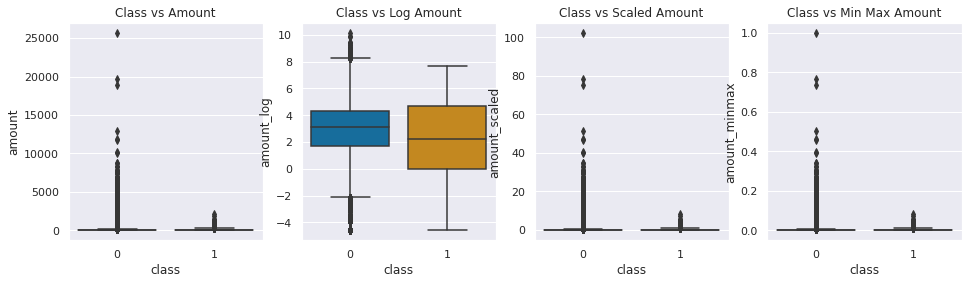

In [20]:
#Feature engineering to a better visualization of the values

# Let's explore the Amount by Class and see the distribuition of Amount transactions
fig , axs = plt.subplots(nrows = 1 , ncols = 4 , figsize = (16,4))

sns.boxplot(x ="class",y="amount",data=df, ax = axs[0])
axs[0].set_title("Class vs Amount")

sns.boxplot(x ="class",y="amount_log",data=df, ax = axs[1])
axs[1].set_title("Class vs Log Amount")

sns.boxplot(x ="class",y="amount_scaled",data=df, ax = axs[2])
axs[2].set_title("Class vs Scaled Amount")

sns.boxplot(x ="class",y="amount_minmax",data=df, ax = axs[3])
axs[3].set_title("Class vs Min Max Amount")

# fig.suptitle('Amount by Class', fontsize=20)
plt.show()

**Hightlights**

* We can see a slight difference in the log amount of our two Classes. 
* The IQR of fraudulent transactions are higher than normal transactions, but normal transactions have the highest values.
* **By seeing the above three graphs, I think scaling the amount by log will best suit for our model.**

# <a id='pickle'>Saving preprossed data as serialized files</a>
* To deploy the predictive models built we save them along with the required data files as serialized file objects
* We save cleaned and processed input data, tuned predictive models as files so that they can later be re-used/shared

In [21]:
CreditCardFraudDataCleaned = df

# Saving the Python objects as serialized files can be done using pickle library
# Here let us save the Final Data set after all the transformations as a file
with open('CreditCardFraudDataCleaned.pkl', 'wb') as fileWriteStream:
    pickle.dump(CreditCardFraudDataCleaned, fileWriteStream)
    # Don't forget to close the filestream!
    fileWriteStream.close()
    
print('pickle file is saved at Location:',os.getcwd())

pickle file is saved at Location: /kaggle/working


### Load preprocessed data

In [22]:
# Reading a Pickle file
with open('CreditCardFraudDataCleaned.pkl', 'rb') as fileReadStream:
    CreditCardFraudDataFromPickle = pickle.load(fileReadStream)
    # Don't forget to close the filestream!
    fileReadStream.close()
    
# Checking the data read from pickle file. It is exactly same as the DiamondPricesData
df = CreditCardFraudDataFromPickle
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,class,amount_log,amount_scaled,amount_minmax
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,5.008166,0.244964,0.005824
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.993252,-0.342475,0.000105
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,5.936665,1.160686,0.014739
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,4.816322,0.140534,0.004807
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,4.248495,-0.073403,0.002724


In [23]:
df.shape

(284807, 34)

# <a id='splitdata'>Splitting data into Training and Testing samples</a>

We don't use the full data for creating the model. Some data is randomly selected and kept aside for checking how good the model is. This is known as Testing Data and the remaining data is called Training data on which the model is built. Typically 70% of data is used as training data and the rest 30% is used as testing data.

In [24]:
# Separate Target Variable and Predictor Variables
# Here I am keeping the log amount and dropping the amount and scaled amount columns.
X = df.drop(['time','class','amount'],axis=1)
y = df['class']

In [25]:
X

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount_log,amount_scaled,amount_minmax
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.008166,0.244964,0.005824
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.993252,-0.342475,0.000105
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.936665,1.160686,0.014739
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.816322,0.140534,0.004807
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.248495,-0.073403,0.002724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.248461,-0.350151,0.000030
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,3.210844,-0.254117,0.000965
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,4.217889,-0.081839,0.002642
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,2.303585,-0.313249,0.000389


In [26]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=101)

In [27]:
# Quick sanity check with the shapes of Training and testing datasets
print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

X_train -  (199364, 31)
y_train -  (199364,)
X_test -  (85443, 31)
y_test -  (85443,)


# <a id='modelbaseline'>Baseline for models</a>

We will train four types of classifiers and decide which classifier will be more effective in detecting **fraud transactions**.

#### Let's Discuss Next Steps - 

1  __Classification Models__

- Logistic Regression
- Decision Trees
- Random Forest
- Naive Bayes Classifier 

2  __Class Imbalance Solutions__

- Under Sampling
- Over Sampling
- SMOTE
- ADASYN

3  __Metrics__

- Accuracy Score
- Confusion Matrix
- Precision Score
- Recall Score
- ROC_AUC
- F1 Score

# <a id='modelbuild'>Model Building</a>

##### We are aware that our dataset is highly imbalanced, however, we check the performance of imbalance dataset first and later we implement some techniques to balance the dataset and again check the performance of balanced dataset. Finally, we will compare each regression models performance.

# <a id='logreg'>1. Logistic Regression</a>

## <a id='logregim'>1.1 Logistic Regression with imbalanced data</a>

In [28]:
from sklearn.linear_model import LogisticRegression # Importing Classifier Step

In [29]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0) 


logreg = LogisticRegression()
logreg.fit(X_train, y_train) 

LogisticRegression()

### Predict from Test set

In [30]:
y_pred = logreg.predict(X_test)

### <a id='modevel'>Model Evolution</a>

In [31]:
from sklearn import metrics

In [32]:
# https://en.wikipedia.org/wiki/Precision_and_recall
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.88      0.62      0.73       144

    accuracy                           1.00     85443
   macro avg       0.94      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [33]:
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_pred , y_test))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_test , y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_test , y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_test , y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_test , y_pred)))
# print('Confusion Matrix : \n', cnf_matrix)
print("\n")

Accuracy :0.99922
AUC : 0.80896
Precision : 0.88119
Recall : 0.61806
F1 : 0.72653




### <a id='modevelmatrix'>Confusion Matrix</a>

Every problem is different and derives a different set of values for a particular business use case , thus every model must be evaluated differently.

**Let's get to know the terminology and Structure first**

A confusion matrix is defined into four parts : __{ TRUE , FALSE } (Actual) ,{POSITIVE , NEGATIVE} (Predicted)__
Positive and Negative is what you predict , True and False is what you are told

Which brings us to 4 relations : True Positive , True Negative , False Positive , False Negative <br>
__P__ redicted - __R__ ows and __A__ ctual as __C__ olumns <br>

<img src = 'https://github.com/dktalaicha/Kaggle/blob/master/CreditCardFraudDetection/images/final_cnf.png?raw=true'>


### Accuracy , Precision and Recall

##### __Accuracy__ : The most used and classic classification metric : Suited for binary classification problems.

$$  \text{Accuracy} = \frac{( TP + TN ) }{ (TP + TN + FP + FN )}$$

Basically Rightly predicted results amongst all the results , used when the classes are balanced

##### __Precision__ : What proportion of predicted positives are truly positive ? Used when we need to predict the positive thoroughly, sure about it !

$$ \text{Precision} = \frac{( TP )}{( TP + FP )} $$

##### __Sensitivity or Recall__ : What proportion of actual positives is correctly classified ? choice when we want to capture as many positives as possible

$$ \text{Recall} = \frac{(TP)}{( TP + FN )} $$

##### __F1 Score__ : Harmonic mean of Precision and Recall. It basically maintains a balance between the precision and recall for your classifier

$$ F1 = \frac{2 * (\text{ precision } * \text{ recall })}{(\text{ precision } + \text{ recall } )} $$

<img src='https://i.imgur.com/IYuqqic.gif' />

**Precision as the name says, says how precise (how sure) is our model in detecting fraud transactions while recall is the amount of fraud cases our model is able to detect.**


**In reference of our case**:

Recall (True Positive Rate): % of all fraudulent transactions cases captured.

Precision: Out of all items labeled as fraud, what percentage of them is actually fraud?

Accuracy: How correct the model is (misleading for fraud/imbalanced data)

F1 score: combination of recall and precision into one metric. F1 score is the weighted average of precision and recall, taking BOTH false positives and false negatives into account. Usually much more useful than accuracy, especially with uneven classes.

In [34]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
cnf_matrix

array([[85287,    12],
       [   55,    89]])

In [35]:
conf_mx = metrics.confusion_matrix(y_test,y_pred)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print ('recall = ', round(recall,3), 'precision = ', round(precision,3))

F1 = 2 * recall * precision / (recall + precision)
print('F1 = ', round(F1,3))

TN:  85287
FP:  12
FN:  55
TP:  89
recall =  0.618 precision =  0.881
F1 =  0.727


In [36]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

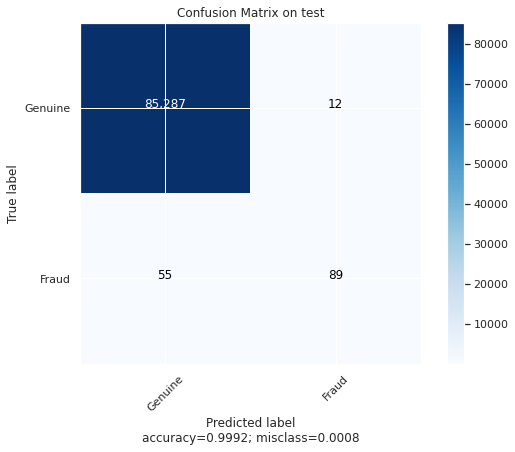

In [37]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['Genuine', 'Fraud'],
                      title        = "Confusion Matrix on test")

f1=0.727


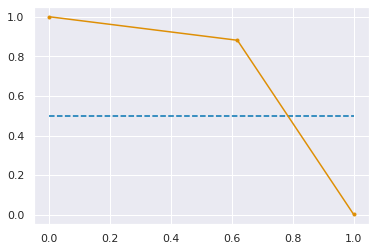

In [38]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# calculate F1 score
f1 = metrics.f1_score(y_test, y_pred)
print('f1=%.3f' % (f1))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()

### <a id='roccurve'>Receiver Operating Characteristics (ROC)</a>

The ROC is a performance measurement for classification problems at various thresholds. It is essentially a probability curve, and the higher the Area Under the Curve (AUC) score the better the model is at predicting fraudulent/non-fraudulent transactions.

It is an evaluation metric that helps identify the strength of the model to **distinguish between two outcomes**. It defines if a model can create a clear boundary between the postive and the negative class. 

<div style='width:100%;'>
   <div style='width:30%; float:left;'> <img  src ='https://i.imgur.com/fzBGUDy.jpg' /> </div>
   <div style=''> <img  src ='https://i.imgur.com/hZQiNCn.png' /> </div>
</div>


Let's talk about some definitions first: 

##### __Sensitivity__ or __Recall__

The sensitivity of a model is defined by the proportion of actual positives that are classified as Positives , i.e = TP / ( TP + FN )

$$ \text{Recall or Sensitivity} = \frac{(TP)}{( TP + FN )} $$

<img src = "https://github.com/dktalaicha/Kaggle/blob/master/CreditCardFraudDetection/images/sens.png?raw=true">

##### __Specificity__

The specificity of a model is defined by the proportion of actual negatives that are classified as Negatives , i.e = TN / ( TN + FP )

$$ \text{Specificity} = \frac{(TN)}{( TN + FP )} $$

<img src = "https://github.com/dktalaicha/Kaggle/blob/master/CreditCardFraudDetection/images/spec.png?raw=true">

As we can see that both are independent of each other and lie in teo different quadrants , we can understand that they are inversely related to each other. Thus as Sensitivity goes up , Specificity goes down and vice versa.

### ROC CURVE

It is a plot between Sesitivity and ( 1 - Specificity ) , which intuitively is a plot between True Positive Rate and False Positive Rate. 
It depicts if a model can clearly identify each class or not

Higher the area under the curve , better the model and it's ability to seperate the positive and negative class.

<img src = "https://github.com/dktalaicha/Kaggle/blob/master/CreditCardFraudDetection/images/tpfpfntn.jpeg?raw=true">
<img src = "https://github.com/dktalaicha/Kaggle/blob/master/CreditCardFraudDetection/images/auc.png?raw=true">
<img src = "https://github.com/dktalaicha/Kaggle/blob/master/CreditCardFraudDetection/images/auc2.png?raw=true">

<img src='https://i.imgur.com/GRuZpez.gif'>

# AUC is not a good metric for imbalanced datasets

* Imagine that in the graphs above, one of the groups, the blue right one for example is extremely small...but you can always read about the reasoning of the above statement https://stats.stackexchange.com/questions/262616/roc-vs-precision-recall-curves-on-imbalanced-dataset

In [39]:
metrics.roc_auc_score(y_test , y_pred) 

0.8089574369765961

In [40]:
y_pred_proba = logreg.predict_proba(X_test)
y_pred_proba

array([[9.99571959e-01, 4.28041024e-04],
       [9.99868146e-01, 1.31853716e-04],
       [9.99790889e-01, 2.09111435e-04],
       ...,
       [9.99657791e-01, 3.42208874e-04],
       [9.99702346e-01, 2.97654101e-04],
       [9.99869683e-01, 1.30316966e-04]])

AUC -  0.8089574369765961 



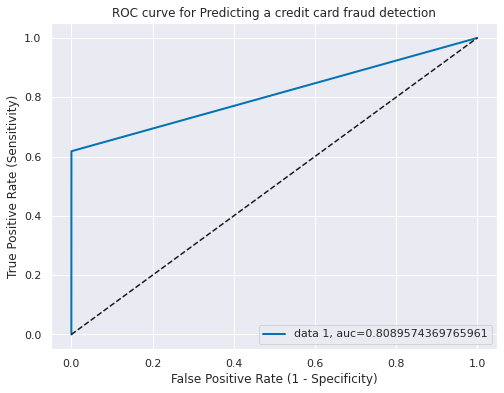

In [41]:
# plot ROC Curve

plt.figure(figsize=(8,6))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

auc = metrics.roc_auc_score(y_test, y_pred)
print("AUC - ",auc,"\n")

plt.plot(fpr,tpr,linewidth=2, label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

# <a id='classimbalance'>Class Imbalance</a>

Imbalanced data typically refers to a problem with classification problems where the classes are not represented equally.  If one applies classifiers on the dataset, they are likely to predict everything as the majority class. This was often regarded as a problem in learning from highly imbalanced datasets.

<img src='https://i.imgur.com/uqh1peJ.gif' />


Let's Fix the class Imbalance and apply some sampling techniques.


Ref : https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

## <a id='undovrsamp'>Under Sampling and Over Sampling</a>

Oversampling and undersampling in data analysis are techniques used to adjust the class distribution of a data set. 

* Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.

* Random undersampling deletes examples from the majority class and can result in losing information invaluable to a model.

<img src = 'https://github.com/dktalaicha/Kaggle/blob/master/CreditCardFraudDetection/images/under_over_sampling.jpg?raw=true'>

## <a id='smote'>Synthetic Minority OverSampling Technique (SMOTE)</a>

In this technique, instead of simply duplicating data from the minority class, we synthesize new data from the minority class. This is a type of data augmentation for tabular data can be very effective. This approach to synthesizing new data is called the Synthetic Minority Oversampling TEchnique, or SMOTE for short. 

<img src='https://github.com/dktalaicha/Kaggle/blob/master/CreditCardFraudDetection/images/smote.png?raw=true'>

## <a id='adasyn'>Adaptive Synthetic Sampling Method for Imbalanced Data (ADASYN)</a>

ADASYN (Adaptive Synthetic) is an algorithm that generates synthetic data, and its greatest advantages are not copying the same minority data, and generating more data for “harder to learn” examples.

Ref : https://medium.com/@ruinian/an-introduction-to-adasyn-with-code-1383a5ece7aa

## Import imbalace technique algorithms

In [42]:
# Import imbalace technique algorithims
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

## <a id='logregundsamp'>1.2.Logistic Regression with Random Undersampling technique</a>

In [43]:
from collections import Counter # counter takes values returns value_counts dictionary
from sklearn.datasets import make_classification

In [44]:
# Split BEFORE any oversampling - prevent data leakage

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

X_train -  (199364, 31)
y_train -  (199364,)
X_test -  (85443, 31)
y_test -  (85443,)


In [45]:
# Undersampling only on train

print('Original dataset shape %s' % Counter(y_train))
random_state = 42

rus = RandomUnderSampler(random_state=random_state)
X_res, y_res = rus.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

X_train = X_res
y_train = y_res

print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

Original dataset shape Counter({0: 199019, 1: 345})
Resampled dataset shape Counter({0: 345, 1: 345})
X_train -  (690, 31)
y_train -  (690,)
X_test -  (85443, 31)
y_test -  (85443,)


In [46]:
# Undersampling with Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [47]:
conf_mx = metrics.confusion_matrix(y_test,y_pred)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print ('recall = ', round(recall,3), 'precision = ', round(precision,3))

F1 = 2 * recall * precision / (recall + precision)
print('F1 = ', round(F1,3))

TN:  83085
FP:  2211
FN:  13
TP:  134
recall =  0.912 precision =  0.057
F1 =  0.108


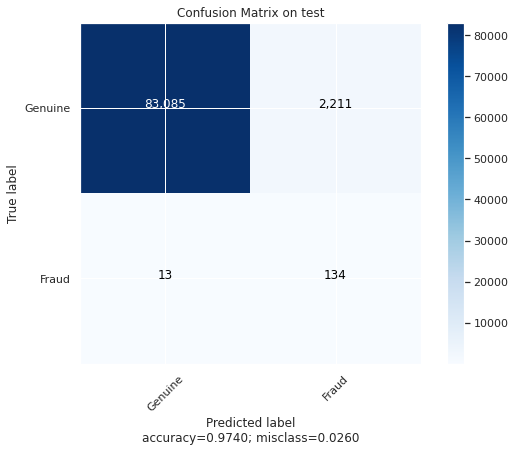

In [48]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['Genuine', 'Fraud'],
                      title        = "Confusion Matrix on test")

In [49]:
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_pred , y_test))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_test , y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_test , y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_test , y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_test , y_pred)))

Accuracy :0.97397
AUC : 0.94282
Precision : 0.05714
Recall : 0.91156
F1 : 0.10754


f1=0.108


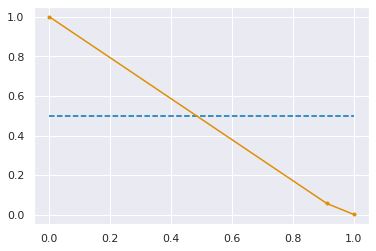

In [50]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# calculate F1 score
f1 = metrics.f1_score(y_test, y_pred)
print('f1=%.3f' % (f1))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()

## <a id='logregovrsamp'>1.3.Logistic Regression with Random Oversampling technique</a>

In [51]:
from imblearn.over_sampling import RandomOverSampler

# Modified the original nb so the test is separated BEFORE any oversampling - to prevent data leakage

Identical samples in the train AND test = data leakage....

Oversampling is performed ONLY on train

In [52]:
# Split BEFORE any oversampling - prevent data leakage

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

X_train -  (199364, 31)
y_train -  (199364,)
X_test -  (85443, 31)
y_test -  (85443,)


In [53]:
# Oversampling only on train

print('Original dataset shape %s' % Counter(y_train))
random_state = 42

ros = RandomOverSampler(random_state=random_state)
X_res, y_res = ros.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

X_train = X_res
y_train = y_res

print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

Original dataset shape Counter({0: 199019, 1: 345})
Resampled dataset shape Counter({0: 199019, 1: 199019})
X_train -  (398038, 31)
y_train -  (398038,)
X_test -  (85443, 31)
y_test -  (85443,)


In [54]:
# Oversampling with Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [55]:
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_test , y_pred))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_test , y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_test , y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_test , y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_test , y_pred)))

Accuracy :0.97717
AUC : 0.94442
Precision : 0.06467
Recall : 0.91156
F1 : 0.12078


### F1 on test: 0.94 with data leakage vs 0.12 without 

In [56]:
conf_mx = metrics.confusion_matrix(y_test,y_pred)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print ('recall = ', round(recall,3), 'precision = ', round(precision,3))

F1 = 2 * recall * precision / (recall + precision)
print('F1 = ', round(F1,3))

TN:  83358
FP:  1938
FN:  13
TP:  134
recall =  0.912 precision =  0.065
F1 =  0.121


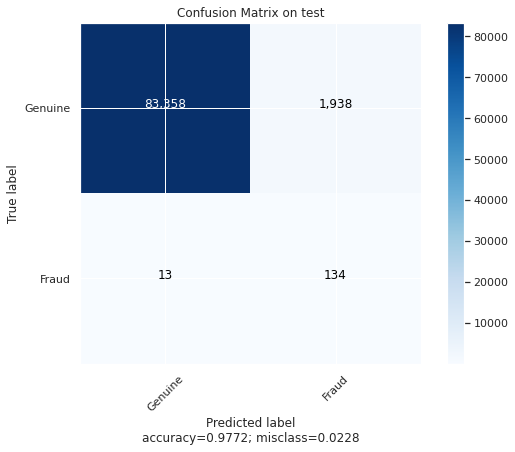

In [57]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['Genuine', 'Fraud'],
                      title        = "Confusion Matrix on test")

## <a id='logregsomote'>1.4 Logistic Regression with SMOTE data</a>

In [58]:
from imblearn.over_sampling import SMOTE, ADASYN

In [59]:
# Split BEFORE any oversampling - prevent data leakage

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

X_train -  (199364, 31)
y_train -  (199364,)
X_test -  (85443, 31)
y_test -  (85443,)


In [60]:
# Oversampling only on train

print('Original dataset shape %s' % Counter(y_train))
random_state = 42

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

X_train = X_res
y_train = y_res

print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

Original dataset shape Counter({0: 199019, 1: 345})
Resampled dataset shape Counter({0: 199019, 1: 199019})
X_train -  (398038, 31)
y_train -  (398038,)
X_test -  (85443, 31)
y_test -  (85443,)


In [61]:

# SMOTE Sampling with Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [62]:
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_test , y_pred))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_test , y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_test , y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_test , y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_test , y_pred)))

Accuracy :0.97561
AUC : 0.94704
Precision : 0.06117
Recall : 0.91837
F1 : 0.11470


In [63]:
conf_mx = metrics.confusion_matrix(y_test,y_pred)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print ('recall = ', round(recall,3), 'precision = ', round(precision,3))

F1 = 2 * recall * precision / (recall + precision)
print('F1 = ', round(F1,3))

TN:  83224
FP:  2072
FN:  12
TP:  135
recall =  0.918 precision =  0.061
F1 =  0.115


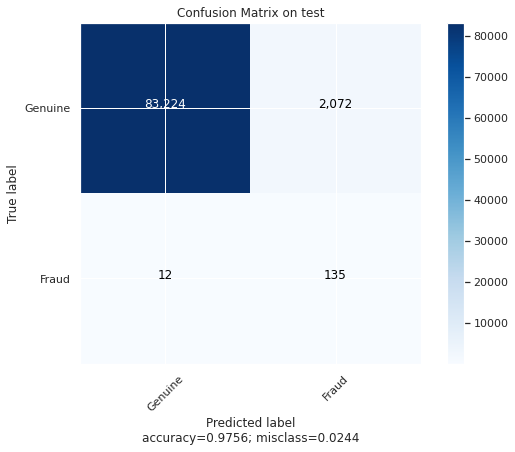

In [64]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['Genuine', 'Fraud'],
                      title        = "Confusion Matrix on test")


### F1 on test: 0.94 with data leakage vs 0.12 without 

## <a id='logregadasyn'>1.5 Logistic Regression with ADASYN data</a>

In [65]:
# Split BEFORE any oversampling - prevent data leakage

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

X_train -  (199364, 31)
y_train -  (199364,)
X_test -  (85443, 31)
y_test -  (85443,)


In [66]:
# Oversampling only on train

print('Original dataset shape %s' % Counter(y_train))
random_state = 42

adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

X_train = X_res
y_train = y_res

print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

Original dataset shape Counter({0: 199019, 1: 345})
Resampled dataset shape Counter({1: 199059, 0: 199019})
X_train -  (398078, 31)
y_train -  (398078,)
X_test -  (85443, 31)
y_test -  (85443,)


In [67]:

#  ADASYN Sampling with Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [68]:
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_pred , y_test))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_test , y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_test , y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_test , y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_test , y_pred)))

Accuracy :0.91359
AUC : 0.92956
Precision : 0.01850
Recall : 0.94558
F1 : 0.03629


In [69]:
conf_mx = metrics.confusion_matrix(y_test,y_pred)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print ('recall = ', round(recall,3), 'precision = ', round(precision,3))

F1 = 2 * recall * precision / (recall + precision)
print('F1 = ', round(F1,3))

TN:  77921
FP:  7375
FN:  8
TP:  139
recall =  0.946 precision =  0.018
F1 =  0.036


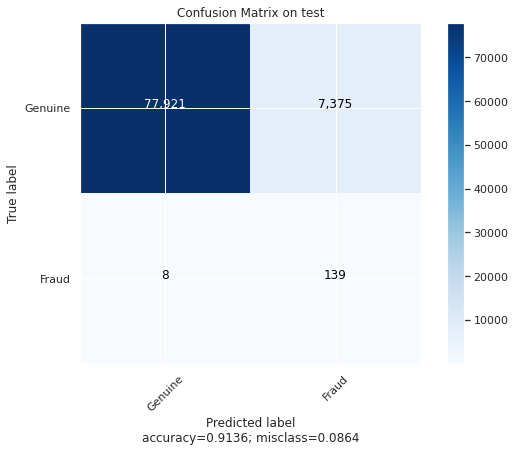

In [70]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['Genuine', 'Fraud'],
                      title        = "Confusion Matrix on test")

### F1 on test: 0.87 with data leakage vs 0.03 without 

# <a id='spatial'>Spatial nature of class imbalance</a>

I will reduce 29 columns to 2 columns with the help of **Principal Component Analysis** so that I can look at them in a plot! (because to plot graph we need two dimensions)

In [71]:
from sklearn.decomposition import PCA

##  <a id='distimbds'>Distribution of balaced dataset</a>

Finally, we can create a scatter plot of the dataset and colour the examples for each class a different colour to clearly see the spatial nature of the class imbalance.

A scatter plot of the dataset is created showing the large mass of points that belong to the minority class (red) and a small number of points spread out for the minority class (blue). We can see some measure of overlap between the two classes.

In [72]:
X_reduced_pca_im = PCA(n_components=2, random_state=42).fit_transform(X)

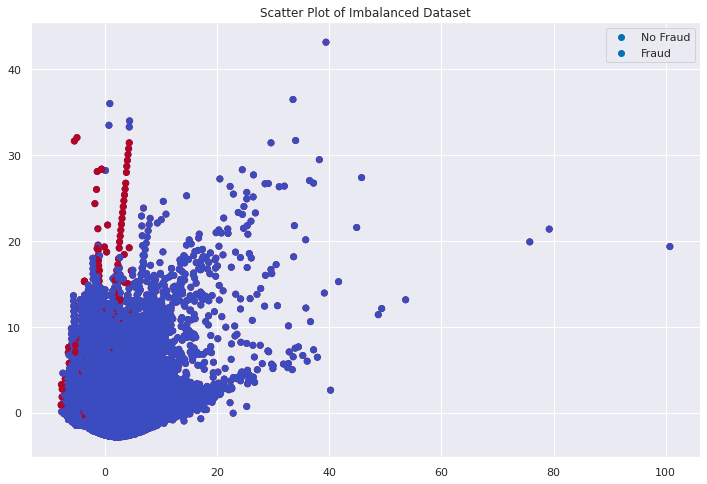

In [73]:
# Generate and plot a synthetic imbalanced classification dataset
plt.figure(figsize=(12,8))

plt.scatter(X_reduced_pca_im[:,0], X_reduced_pca_im[:,1], c=(y == 0), label='No Fraud', cmap='coolwarm', linewidths=1)
plt.scatter(X_reduced_pca_im[:,0], X_reduced_pca_im[:,1], c=(y == 1), label='Fraud', cmap='coolwarm', linewidths=1)

plt.title("Scatter Plot of Imbalanced Dataset")
plt.legend()
plt.show()

# <a id='modelwith'>Building different models with different balanced datasets</a>
Let's now try different models , first by creating multiple datasets for undersampled , oversampled and SMOTE sampled

## <a id='usdata'>1. Undersampled Data</a>

In [74]:
# Split BEFORE any under / oversampling - prevent data leakage

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)
print('-'*50)
# Oversampling only on train
#print('Original dataset shape %s' % Counter(y_train))
random_state = 42

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

X_train = X_res
y_train = y_res

# Slit into train and test datasets
X_train_under, X_test_under, y_train_under, y_test_under = X_train, X_test, y_train, y_test

print("X_train_under - ",X_train_under.shape)
print("y_train_under - ",y_train_under.shape)
print("X_test_under - ",X_test_under.shape)
print("y_test_under - ",y_test_under.shape)

X_train -  (199364, 31)
y_train -  (199364,)
X_test -  (85443, 31)
y_test -  (85443,)
--------------------------------------------------
X_train_under -  (690, 31)
y_train_under -  (690,)
X_test_under -  (85443, 31)
y_test_under -  (85443,)


## <a id='osdata'>2. Oversampled Data</a>

In [75]:
# Split BEFORE any oversampling - prevent data leakage

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)
print('-'*50)
# Oversampling only on train
print('Original dataset shape %s' % Counter(y_train))
random_state = 42

ros = RandomOverSampler(random_state=random_state)
X_res, y_res = ros.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

X_train = X_res
y_train = y_res
X_train_over, X_test_over, y_train_over, y_test_over = X_train, X_test, y_train, y_test

print("X_train_over - ",X_train_over.shape)
print("y_train_over - ",y_train_over.shape)
print("X_test_over - ",X_test_over.shape)
print("y_test_over - ",y_test_over.shape)

X_train -  (199364, 31)
y_train -  (199364,)
X_test -  (85443, 31)
y_test -  (85443,)
--------------------------------------------------
Original dataset shape Counter({0: 199019, 1: 345})
Resampled dataset shape Counter({0: 199019, 1: 199019})
X_train_over -  (398038, 31)
y_train_over -  (398038,)
X_test_over -  (85443, 31)
y_test_over -  (85443,)


## <a id='smotedata'>3. SMOTE Data</a>

In [76]:
# Split BEFORE any oversampling - prevent data leakage

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)
print('-'*50)
# Oversampling only on train
print('Original dataset shape %s' % Counter(y_train))
random_state = 42

smote = SMOTE(random_state=42)
X_res, y_res  = smote.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

X_train = X_res
y_train = y_res
X_train_smote, X_test_smote, y_train_smote, y_test_smote = X_train, X_test, y_train, y_test

print("X_train_smote - ",X_train_smote.shape)
print("y_train_smote - ",y_train_smote.shape)
print("X_test_smote - ",X_test_smote.shape)
print("y_test_smote - ",y_test_smote.shape)

X_train -  (199364, 31)
y_train -  (199364,)
X_test -  (85443, 31)
y_test -  (85443,)
--------------------------------------------------
Original dataset shape Counter({0: 199019, 1: 345})
Resampled dataset shape Counter({0: 199019, 1: 199019})
X_train_smote -  (398038, 31)
y_train_smote -  (398038,)
X_test_smote -  (85443, 31)
y_test_smote -  (85443,)


## <a id='adasyndata'>4. ADASYN Data</a>

In [77]:
# Split BEFORE any oversampling - prevent data leakage

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)
print('-'*50)
# Oversampling only on train
print('Original dataset shape %s' % Counter(y_train))
random_state = 42

adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

X_train = X_res
y_train = y_res
X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = X_train, X_test, y_train, y_test

print("X_train_adasyn - ",X_train_adasyn.shape)
print("y_train_adasyn - ",y_train_adasyn.shape)
print("X_test_adasyn - ",X_test_adasyn.shape)
print("y_test_adasyn - ",y_test_adasyn.shape)

X_train -  (199364, 31)
y_train -  (199364,)
X_test -  (85443, 31)
y_test -  (85443,)
--------------------------------------------------
Original dataset shape Counter({0: 199019, 1: 345})
Resampled dataset shape Counter({1: 199059, 0: 199019})
X_train_adasyn -  (398078, 31)
y_train_adasyn -  (398078,)
X_test_adasyn -  (85443, 31)
y_test_adasyn -  (85443,)


In [78]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

### Function to create the datasets for under, oversampling and capture their performance

In [79]:
names_lst = []

# Empty list to capture performance matrix for train set
aucs_train_lst = []
accuracy_train_lst = []
precision_train_lst = []
recall_train_lst = []
f1_train_lst = []

# Empty list to capture performance matrix for test set
aucs_test_lst = []
accuracy_test_lst = []
precision_test_lst = []
recall_test_lst = []
f1_test_lst = []

# Function for model building and performance measure

def build_measure_model(models):
    #plt.figure(figsize=(12,6))

    for name, model, X_train, X_test, y_train, y_test in models:
        
        names_lst.append(name)

        # split data in train test set
        X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test
        
        # Build model
        model.fit(X_train, y_train)
        
        # Predict
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # calculate accuracy
        Accuracy_train = metrics.accuracy_score(y_train, y_train_pred)
        accuracy_train_lst.append(Accuracy_train)
        
        Accuracy_test = metrics.accuracy_score(y_test, y_test_pred)
        accuracy_test_lst.append(Accuracy_test)

        # calculate auc
        Aucs_train = metrics.roc_auc_score(y_train, y_train_pred)
        aucs_train_lst.append(Aucs_train)
        
        Aucs_test = metrics.roc_auc_score(y_test , y_test_pred)
        aucs_test_lst.append(Aucs_test)

        # calculate precision
        PrecisionScore_train = metrics.precision_score(y_train , y_train_pred)
        precision_train_lst.append(PrecisionScore_train)
        
        PrecisionScore_test = metrics.precision_score(y_test , y_test_pred)
        precision_test_lst.append(PrecisionScore_test)

        # calculate recall
        RecallScore_train = metrics.recall_score(y_train , y_train_pred)
        recall_train_lst.append(RecallScore_train)
        
        RecallScore_test = metrics.recall_score(y_test , y_test_pred)
        recall_test_lst.append(RecallScore_test)

        # calculate f1 score
        F1Score_train = metrics.f1_score(y_train , y_train_pred)
        f1_train_lst.append(F1Score_train)
        
        F1Score_test = metrics.f1_score(y_test , y_test_pred)
        f1_test_lst.append(F1Score_test)

        #print('F1 Score of '+ name +' model : {0:0.5f}'.format(F1Score_test))

        # draw confusion matrix
        cnf_matrix = metrics.confusion_matrix(y_test , y_test_pred)

        print("Model Name :", name)
        
        #print('Train Accuracy :{0:0.5f}'.format(Accuracy_train)) 
        print('Test Accuracy :{0:0.5f}'.format(Accuracy_test))
        
        #print('Train AUC : {0:0.5f}'.format(Aucs_train))
        print('Test AUC : {0:0.5f}'.format(Aucs_test))
        
        #print('Train Precision : {0:0.5f}'.format(PrecisionScore_train))
        print('Test Precision : {0:0.5f}'.format(PrecisionScore_test))
        
        #print('Train Recall : {0:0.5f}'.format(RecallScore_train))
        print('Test Recall : {0:0.5f}'.format(RecallScore_test))
        
        #print('Train F1 : {0:0.5f}'.format(F1Score_train))
        print('Test F1 : {0:0.5f}'.format(F1Score_test))
        
        print('Confusion Matrix : \n', cnf_matrix)
        print("\n")


### Logistic Regression (LR)

In [80]:
#------------------ Logistic Regression (LR) ------------------#
LRmodels = []

#LRmodels.append(('LR imbalance', LogisticRegression(solver='liblinear', multi_class='ovr'),X,y))
LRmodels.append(('LR Undersampling', LogisticRegression(solver='liblinear', multi_class='ovr'),X_train_under, X_test_under, y_train_under, y_test_under))
LRmodels.append(('LR Oversampling', LogisticRegression(solver='liblinear', multi_class='ovr'),X_train_over, X_test_over, y_train_over, y_test_over))
LRmodels.append(('LR SMOTE', LogisticRegression(solver='liblinear', multi_class='ovr'),X_train_smote, X_test_smote, y_train_smote, y_test_smote))
LRmodels.append(('LR ADASYN', LogisticRegression(solver='liblinear', multi_class='ovr'),X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn))

# Call function to create model and measure its performance
build_measure_model(LRmodels)

Model Name : LR Undersampling
Test Accuracy :0.97285
Test AUC : 0.94226
Test Precision : 0.05490
Test Recall : 0.91156
Test F1 : 0.10355
Confusion Matrix : 
 [[82989  2307]
 [   13   134]]


Model Name : LR Oversampling
Test Accuracy :0.97718
Test AUC : 0.94443
Test Precision : 0.06470
Test Recall : 0.91156
Test F1 : 0.12083
Confusion Matrix : 
 [[83359  1937]
 [   13   134]]


Model Name : LR SMOTE
Test Accuracy :0.97561
Test AUC : 0.94704
Test Precision : 0.06117
Test Recall : 0.91837
Test F1 : 0.11470
Confusion Matrix : 
 [[83224  2072]
 [   12   135]]


Model Name : LR ADASYN
Test Accuracy :0.91364
Test AUC : 0.92958
Test Precision : 0.01851
Test Recall : 0.94558
Test F1 : 0.03631
Confusion Matrix : 
 [[77925  7371]
 [    8   139]]




### Decision Tree (DT)

In [81]:
#-----------------Decision Tree (DT)------------------#
DTmodels = []

dt = DecisionTreeClassifier()

#DTmodels.append(('DT imbalance', dt,X,y))
DTmodels.append(('DT Undersampling', dt, X_train_under, X_test_under, y_train_under, y_test_under))
DTmodels.append(('DT Oversampling', dt,X_train_over, X_test_over, y_train_over, y_test_over))
DTmodels.append(('DT SMOTE', dt,X_train_smote, X_test_smote, y_train_smote, y_test_smote))
DTmodels.append(('DT ADASYN', dt ,X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn))

# Call function to create model and measure its performance
build_measure_model(DTmodels)

Model Name : DT Undersampling
Test Accuracy :0.90326
Test AUC : 0.90061
Test Precision : 0.01575
Test Recall : 0.89796
Test F1 : 0.03095
Confusion Matrix : 
 [[77045  8251]
 [   15   132]]


Model Name : DT Oversampling
Test Accuracy :0.99920
Test AUC : 0.87057
Test Precision : 0.78417
Test Recall : 0.74150
Test F1 : 0.76224
Confusion Matrix : 
 [[85266    30]
 [   38   109]]


Model Name : DT SMOTE
Test Accuracy :0.99723
Test AUC : 0.88656
Test Precision : 0.35849
Test Recall : 0.77551
Test F1 : 0.49032
Confusion Matrix : 
 [[85092   204]
 [   33   114]]


Model Name : DT ADASYN
Test Accuracy :0.99800
Test AUC : 0.85978
Test Precision : 0.44915
Test Recall : 0.72109
Test F1 : 0.55352
Confusion Matrix : 
 [[85166   130]
 [   41   106]]




### Random Forest (RF)

In [82]:
#-----------------Random Forest (RF) ------------------#
RFmodels = []

#RFmodels.append(('RF imbalance', RandomForestClassifier(),X,y))
RFmodels.append(('RF Undersampling', RandomForestClassifier(),X_train_under, X_test_under, y_train_under, y_test_under))
RFmodels.append(('RF Oversampling', RandomForestClassifier(),X_train_over, X_test_over, y_train_over, y_test_over))
RFmodels.append(('RF SMOTE', RandomForestClassifier(),X_train_smote, X_test_smote, y_train_smote, y_test_smote))
RFmodels.append(('RF ADASYN', RandomForestClassifier(),X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn))

# Call function to create model and measure its performance
build_measure_model(RFmodels)

Model Name : RF Undersampling
Test Accuracy :0.98353
Test AUC : 0.93742
Test Precision : 0.08607
Test Recall : 0.89116
Test F1 : 0.15698
Confusion Matrix : 
 [[83905  1391]
 [   16   131]]


Model Name : RF Oversampling
Test Accuracy :0.99953
Test AUC : 0.88432
Test Precision : 0.94958
Test Recall : 0.76871
Test F1 : 0.84962
Confusion Matrix : 
 [[85290     6]
 [   34   113]]


Model Name : RF SMOTE
Test Accuracy :0.99954
Test AUC : 0.90809
Test Precision : 0.90909
Test Recall : 0.81633
Test F1 : 0.86022
Confusion Matrix : 
 [[85284    12]
 [   27   120]]


Model Name : RF ADASYN
Test Accuracy :0.99954
Test AUC : 0.90130
Test Precision : 0.92188
Test Recall : 0.80272
Test F1 : 0.85818
Confusion Matrix : 
 [[85286    10]
 [   29   118]]




##------------------ K-Nearest Neighbors (KNN) ------------------#

KNNmodels = []

KNNmodels.append(('KNN Undersampling', KNeighborsClassifier(),X_train_under, X_test_under, y_train_under, y_test_under))
KNNmodels.append(('KNN Oversampling', KNeighborsClassifier(),X_train_over, X_test_over, y_train_over, y_test_over))
KNNmodels.append(('KNN SMOTE', KNeighborsClassifier(),X_train_smote, X_test_smote, y_train_smote, y_test_smote))
KNNmodels.append(('KNN ADASYN', KNeighborsClassifier(),X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn))


build_measure_model(KNNmodels)

##------------------ Support Vector Machines (SVM) ------------------#

SVMmodels = []

SVMmodels.append(('SVM imbalance', SVC(gamma='auto'),X,y))
SVMmodels.append(('SVM Undersampling', SVC(gamma='auto'),X_under,y_under))
SVMmodels.append(('SVM Oversampling', SVC(gamma='auto'),X_over,y_over))
SVMmodels.append(('SVM SMOTE', SVC(gamma='auto'),X_smote,y_smote))
SVMmodels.append(('SVM ADASYN', SVC(gamma='auto'),X_adasyn,y_adasyn))

build_measure_model(SVMmodels)

In [83]:
# Display comparison of the models performance

data = {'Model':names_lst,
       #'Accuracy_Train':accuracy_train_lst,
       #'Accuracy_Test':accuracy_test_lst,
       #'AUC_Train':aucs_train_lst,
       #'AUC_Test':aucs_test_lst,
       #'PrecisionScore_Train':precision_train_lst,
       'PrecisionScore_Test':precision_test_lst,
       #'RecallScore_Train':recall_train_lst,
       'RecallScore_Test':recall_test_lst,
       #'F1Score_Train':f1_train_lst,
       'F1Score_Test':f1_test_lst}

print("Performance measures of various classifiers: \n")
performance_df = pd.DataFrame(data) 
performance_df.sort_values(['F1Score_Test'],ascending=False)

Performance measures of various classifiers: 



,Model,PrecisionScore_Test,RecallScore_Test,F1Score_Test
10,RF SMOTE,0.909091,0.816327,0.860215
11,RF ADASYN,0.921875,0.802721,0.858182
9,RF Oversampling,0.949580,0.768707,0.849624
5,DT Oversampling,0.784173,0.741497,0.762238
7,DT ADASYN,0.449153,0.721088,0.553525
6,DT SMOTE,0.358491,0.775510,0.490323
8,RF Undersampling,0.086071,0.891156,0.156980
1,LR Oversampling,0.064703,0.911565,0.120830
2,LR SMOTE,0.061169,0.918367,0.114698
0,LR Undersampling,0.054896,0.911565,0.103555


### NN

In [84]:
import tensorflow as tf

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

Using TensorFlow backend.


In [85]:
# F1 function as there is none in Keras metrics
# https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [86]:
# NN model

model = models.Sequential()
model.add(layers.Dense(2048, activation='relu', input_shape=(31,)))
#model.add(layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(30,)))
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
#model.add(layers.Dropout(0.5))
#model.add(layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))



model.compile(optimizer=optimizers.Adam(lr=1e-4), 
              loss='binary_crossentropy', 
              metrics=[get_f1])
              #metrics=['binary_accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              65536     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 67,585
Trainable params: 67,585
Non-trainable params: 0
_________________________________________________________________
None


In [87]:
# Pick one of the four: under, over, smote or adasyn

X_train, y_train, X_test, y_test = X_train_over, y_train_over, X_test_over, y_test_over

print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

X_train -  (398038, 31)
y_train -  (398038,)
X_test -  (85443, 31)
y_test -  (85443,)


In [88]:
# FIT / TRAIN model

NumEpochs = 10
BatchSize = 16

history = model.fit(X_train, y_train, epochs=NumEpochs, batch_size=BatchSize, validation_split = 0.2)

Epoch 1/10
19902/19902 [==============================] - 42s 2ms/step - loss: 0.0325 - get_f1: 0.9851 - val_loss: 0.0104 - val_get_f1: 1.0000
Epoch 2/10
19902/19902 [==============================] - 41s 2ms/step - loss: 0.0059 - get_f1: 0.9977 - val_loss: 0.0018 - val_get_f1: 1.0000
Epoch 3/10
19902/19902 [==============================] - 42s 2ms/step - loss: 0.0036 - get_f1: 0.9983 - val_loss: 0.0021 - val_get_f1: 1.0000
Epoch 4/10
19902/19902 [==============================] - 42s 2ms/step - loss: 0.0027 - get_f1: 0.9987 - val_loss: 9.5131e-04 - val_get_f1: 1.0000
Epoch 5/10
19902/19902 [==============================] - 43s 2ms/step - loss: 0.0023 - get_f1: 0.9991 - val_loss: 5.7703e-04 - val_get_f1: 1.0000
Epoch 6/10
19902/19902 [==============================] - 42s 2ms/step - loss: 0.0019 - get_f1: 0.9990 - val_loss: 0.0013 - val_get_f1: 1.0000
Epoch 7/10
19902/19902 [==============================] - 42s 2ms/step - loss: 0.0015 - get_f1: 0.9988 - val_loss: 8.0368e-04 - val_ge

In [89]:
results = model.evaluate(X_test, y_test)
print("_"*100)
print("Test Loss and Metric (acc or f1)")
print("results ", results)
history_dict = history.history
history_dict.keys()

2671/2671 [==============================] - 3s 1ms/step - loss: 0.0088 - get_f1: 0.0438
____________________________________________________________________________________________________
Test Loss and Metric (acc or f1)
results  [0.008830993436276913, 0.04380381852388382]


dict_keys(['loss', 'get_f1', 'val_loss', 'val_get_f1'])

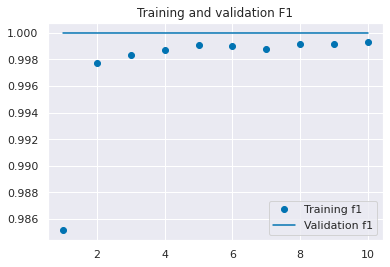

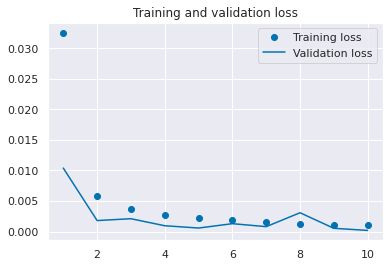

In [90]:
# Learning curves for F1

f1 = history.history['get_f1'] 
val_f1 = history.history['val_get_f1'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
epochs = range(1, len(f1) + 1) 
plt.plot(epochs, f1, 'bo', label='Training f1') 
plt.plot(epochs, val_f1, 'b', label='Validation f1') 
plt.title('Training and validation F1') 
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend() 
plt.show()


plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']
epochs = range(1, (len(history_dict['binary_accuracy']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [91]:
# Final Fit / Predict
# NOTE final_predictions is a list of probabilities

final_predictions = model.predict(X_test)
final_predictions.shape

(85443, 1)

In [92]:
# Modify the raw final_predictions - prediction probs into 0 and 1

Preds = final_predictions.copy()
#print(len(Preds))
#print(Preds)
Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0

In [93]:
# Confusion matrix

from sklearn import metrics
conf_mx = metrics.confusion_matrix(y_test, Preds)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print (recall, precision)

TN:  85259
FP:  37
FN:  26
TP:  121
0.8231292517006803 0.7658227848101266


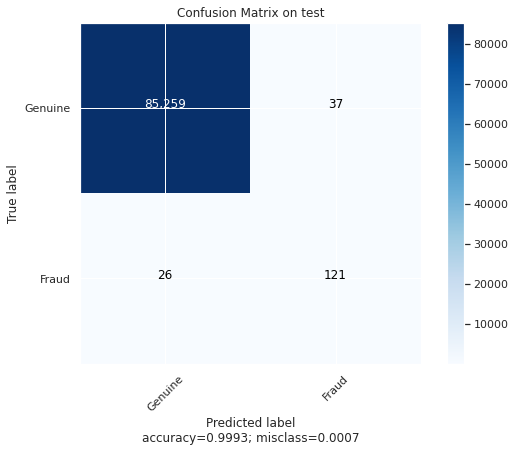

In [94]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['Genuine', 'Fraud'],
                      title        = "Confusion Matrix on test")

In [95]:
print ('precision ',precision_score(y_test, Preds))
print ('recall ',recall_score(y_test, Preds) )
print ('accuracy ',accuracy_score(y_test, Preds))
print ('F1 score ',f1_score(y_test, Preds))

precision  0.7658227848101266
recall  0.8231292517006803
accuracy  0.9992626663389628
F1 score  0.7934426229508198


### Optimizing on accuracy:

* NN - under ... F1 = 0.17
* NN - smote ... F1 = 0.76



### Optimizing on F1:

* NN - over ... F1 = 0.82
* NN - smote ... F1 = 0.81
* NN - adasyn ... F1 = 0.79

